In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('model/trainer_state.json', 'rt') as f:
    data = json.load(f)

In [3]:
eval_loss = {}
train_loss = {}
for x in data['log_history']:
    if 'loss' in x.keys():
        train_loss[x['epoch']] = x['loss']
    else:
        eval_loss[x['epoch']] = x['eval_loss']

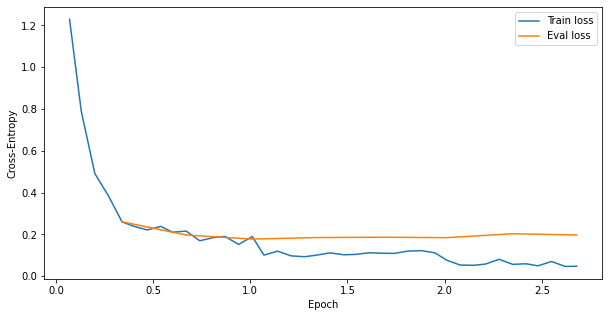

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss.keys(), train_loss.values(), label='Train loss')
plt.plot(eval_loss.keys(), eval_loss.values(), label='Eval loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()